# Import des bibliothèques

In [ ]:
import pyarrow.dataset as ds
import os
import pyarrow as pa
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
import seaborn as sns
import sys
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1 - Importation des données météorologiques

Les données utilisées sont celles des stations météorologiques de MétéoFrance, téléchargées sous forme de fichier parquet depuis le site data.gouv. Plus particulièrement, il s'agit des données météorologiques issues des stations météorologiques parisienne, heure par heure, de 2020 à 2025. Nous ne conservons que les colonnes utiles à notre analyse : la température sous abri instantanée (T), la nébulosité totale (N, un indice pour la couverture nuageuse, 9 correspondant à un ciel invisible par brouillard ou autre phénomène météorologique similaire), la nébulosité de la couche nuageuse la plus basse (NBAS), l'insolation horaire (INS, durée pendant laquelle le rayonnement solaire est d'une intensité supérieure à 120W/m2) et l'intensité du rayonnement solaire (INFRAR en J/cm2)

In [42]:
dataset1 = ds.dataset("../data/2020-2023_75.parquet").scanner(columns=['NUM_POSTE','NOM_USUEL','AAAAMMJJHH','T','N','NBAS','INS','INFRAR'])
table1 = dataset1.to_table()
meteo_20202023_75 = table1.to_pandas()

In [43]:
dataset2 = ds.dataset("../data/2024-2025_75.parquet").scanner(columns=['NUM_POSTE','NOM_USUEL','AAAAMMJJHH','T','N','NBAS','INS','INFRAR'])
table2 = dataset2.to_table()
meteo_20242025_75 = table2.to_pandas()

# 2 - Exploration

In [44]:
print(meteo_20202023_75.info())
meteo_20202023_75

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209159 entries, 0 to 209158
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   NUM_POSTE   209159 non-null  Int64  
 1   NOM_USUEL   209159 non-null  object 
 2   AAAAMMJJHH  209159 non-null  Int64  
 3   T           209106 non-null  float64
 4   N           0 non-null       object 
 5   NBAS        0 non-null       object 
 6   INS         70000 non-null   Int64  
 7   INFRAR      0 non-null       object 
dtypes: Int64(3), float64(1), object(4)
memory usage: 13.4+ MB
None


,NUM_POSTE,NOM_USUEL,AAAAMMJJHH,T,N,NBAS,INS,INFRAR
0,75106001,LUXEMBOURG,2020010100,1.6,None,None,<NA>,None
1,75106001,LUXEMBOURG,2020010101,0.9,None,None,<NA>,None
2,75106001,LUXEMBOURG,2020010102,0.1,None,None,<NA>,None
3,75106001,LUXEMBOURG,2020010103,0.2,None,None,<NA>,None
4,75106001,LUXEMBOURG,2020010104,0.6,None,None,<NA>,None
...,...,...,...,...,...,...,...,...
209154,75116008,LONGCHAMP,2023123119,8.8,None,None,0,None
209155,75116008,LONGCHAMP,2023123120,8.2,None,None,0,None
209156,75116008,LONGCHAMP,2023123121,7.9,None,None,0,None
209157,75116008,LONGCHAMP,2023123122,8.0,None,None,0,None


# 3 - Nettoyage des données

On constate que certaines données ne sont pas collectées par les stations météo parisiennes : la nébulosité et l'intensité du rayonnement solaire. De plus de nombreux relevés apparaissent manquants. 
Par ailleurs la date n'est pas dans un format adapté.

In [45]:
meteo_20202023_75.drop(columns=['N','NBAS','INFRAR','INS'], inplace=True) #Suppression des colonnes vides
meteo_20202023_75['AAAAMMJJHH'] = pd.to_datetime(meteo_20202023_75['AAAAMMJJHH'], format='%Y%m%d%H') #Conversion en datetime
meteo_20202023_75.rename(columns={'AAAAMMJJHH':'Date'}, inplace=True) #Renommage de la colonne

In [46]:
meteo_20202023_75.head()

,NUM_POSTE,NOM_USUEL,Date,T
0,75106001,LUXEMBOURG,2020-01-01 00:00:00,1.6
1,75106001,LUXEMBOURG,2020-01-01 01:00:00,0.9
2,75106001,LUXEMBOURG,2020-01-01 02:00:00,0.1
3,75106001,LUXEMBOURG,2020-01-01 03:00:00,0.2
4,75106001,LUXEMBOURG,2020-01-01 04:00:00,0.6


On se retrouve avec un DataFrame contenant les températures mesurées toutes les heures de 2020 à 2023 pour les différentes stations météorologiques de Paris, avec un format de date approprié. On fait subir le même traitement aux données de la période 2024-2025.

In [47]:
meteo_20242025_75.drop(columns=['N','NBAS','INFRAR','INS'], inplace=True) #Suppression des colonnes vides
meteo_20242025_75['AAAAMMJJHH'] = pd.to_datetime(meteo_20242025_75['AAAAMMJJHH'], format='%Y%m%d%H') #Conversion en datetime
meteo_20242025_75.rename(columns={'AAAAMMJJHH':'Date'}, inplace=True) #Renommage de la colonne

Pour nous simplifier la tâche, nous fusionnons nos deux dataframes en un seul contenant toutes les données de température de 2020 à 2025 à Paris. 

In [48]:
meteo_20202025_75 = pd.concat([meteo_20202023_75, meteo_20242025_75], ignore_index=True)

A présent, regardons si il subsiste des données manquantes pour la température.

In [49]:
print(meteo_20202025_75["T"].isna().sum())
print(meteo_20202025_75["T"].size)

496
313009


Sur un total de 313009 données, 496 sont manquantes. Localisons les données manquantes, et tentons d'interpoler en distinguant les données manquantes isolées et les données manquantes groupées.

In [50]:
meteo_20202025_75 = meteo_20202025_75.sort_values(['NUM_POSTE','Date'])
results = []
for station, g in meteo_20202025_75.groupby('NUM_POSTE'):
    g = g.sort_values('Date')
    missing = g['T'].isna()
    if missing.sum() == 0:
        continue
    groups = (missing != missing.shift()).cumsum()
    missing_runs = (missing[missing].groupby(groups).size())
    intervals = (g.loc[missing, 'Date'].groupby(groups).agg(start="min", end="max", length="count"))
    summary = {
        "station": station,
        "total_missing_values": int(missing.sum()),
        "number_of_missing_sequences": int(len(missing_runs)),
        "isolated_sequences": int((missing_runs == 1).sum()),
        "grouped_sequences": int((missing_runs > 1).sum()),
        "max_consecutive_missing": int(missing_runs.max()),
        "mean_consecutive_missing": float(missing_runs.mean())
    }

    results.append((summary, intervals))
    
summary_df = pd.DataFrame([r[0] for r in results])
print(summary_df)

    station  total_missing_values  number_of_missing_sequences  \
0  75106001                     3                            3   
1  75107005                   450                           17   
2  75114001                     1                            1   
3  75114007                    14                            2   
4  75116008                    28                            8   

   isolated_sequences  grouped_sequences  max_consecutive_missing  \
0                   3                  0                        1   
1                   6                 11                      207   
2                   1                  0                        1   
3                   1                  1                       13   
4                   5                  3                       10   

   mean_consecutive_missing  
0                  1.000000  
1                 26.470588  
2                  1.000000  
3                  7.000000  
4                  3.500000  


La station météorologique de la Tour Eiffel (75107005) concentre 450 données manquantes sur 496, on s'autorise pour des raisons de sipmlicité à ne pas tenir compte de ces relevés et de concentrer le travail de reconstruction sur les autres stations météorologiques parisiennes qui présente peu de données manquantes.

In [51]:
meteo_20202025_75 = meteo_20202025_75[meteo_20202025_75["NUM_POSTE"] != 75107005]  # Suppression de la station avec trop de valeurs manquantes

In [54]:
meteo_202025_75 = meteo_20202025_75.pivot_table(index='Date', columns='NUM_POSTE', values='T',aggfunc='mean')
temp_cols = ["LUXEMBOURG","LARIBOISIERE","MONTSOURIS 1","MONTSOURIS 2","LONGCHAMP"]
meteo_202025_75.columns = temp_cols
meteo_202025_75 = meteo_202025_75.reset_index()
meteo_202025_75["n_nan"] = meteo_202025_75.isna().sum(axis=1)
meteo_202025_75["n_nan"].describe()

count    52373.000000
mean         0.000897
std          0.030575
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: n_nan, dtype: float64

On réalise après réorganisation du DataFrame que, dans le pire des cas, à un instant donné, il y a dans le pire des cas 2 données manquantes sur 5 stations, on remplacera ces données par la moyenne des autres températures mesurées à cette date. Compte tenu de la proximité spatiale des stations météorologiques parisiennes, de la grande similarité des données recueillies, ainsi que du faible nombre de données manquantes restantes (46), on remplacera les données manquantes par la moyenne des données disponibles au même instant.

In [55]:
mean = meteo_202025_75[temp_cols].mean()
count = meteo_202025_75[temp_cols].notna().sum(axis=1)
for col in temp_cols:
    meteo_202025_75[col] = meteo_202025_75[col].fillna((mean * count - meteo_202025_75[col]) / (count - 1))

On dispose à présent de données nettoyés et prêtes à l'emploi, que l'on sauvegarde dans un nouveau fichier parquet.

In [60]:
meteo_202025_75.to_parquet("../data/meteofrance_75_2020_2025_cleaned.parquet",engine="pyarrow", index=False)

# 4 - Visualisation des données

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

Prenons à titre d'illustration la premiere journée du jeu de données, celle du 1er janvier 2020, et visualisons l'évolution des températures relevées par les différentes stations météorologiques parisiennes retenues au cours de la journée.

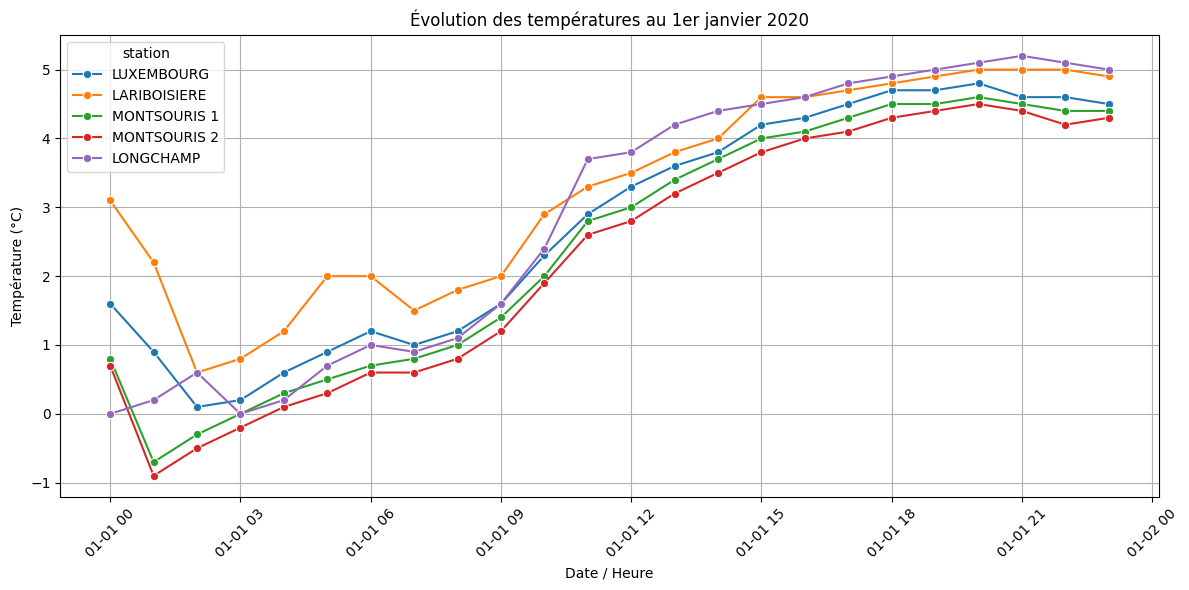

In [58]:
df_24h = meteo_202025_75.sort_values("Date").head(24)
df_long = df_24h.melt(id_vars="Date",value_vars=temp_cols,var_name="station",value_name="temperature")
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_long,
    x="Date",
    y="temperature",
    hue="station",
    marker="o"
)

plt.title("Évolution des températures au 1er janvier 2020")
plt.xlabel("Date / Heure")
plt.ylabel("Température (°C)")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

# 5 - Prise en compte des données de température pour affiner le modèle

Afin d'améliorer la qualité de la prédiction, il est possible de passer d'un modèle ARMA à un modèle ARMAX pour la consommation désaisonnalisée et dé-trendée, notée $\epsilon_t$. 

Un processus ARMAX(p,q) est de la forme $\epsilon_t= \sum_{i=1}^{4} \phi_i \epsilon_{t-i}+ \sum_{j=1}^{2} \theta_j\varepsilon_{t-j}+ \beta^\top Y_t+ \varepsilon_t$ avec $(\varepsilon_t)$ un bruit blanc.

$Y_t$ contient des variables exogènes, on prendra $(Y_t)=(1,T_{t-2},T_{t-1},T_{t})^{\intercal}$, où $T$ est la température à l'heure $t$, car il est raisonnable de supposer dans un premier temps que les variations instantanées de consommation électrique à l'échelle de la ville de Paris dépendent essentiellement des variations de température survenues dans les deux heures précédentes. 

### 5.1 - Importation des données nettoyées et traitées

Importation des données nettoyées de la température quotidienne : 

In [50]:
dataset = ds.dataset("../data/meteofrance_75_2020_2025_cleaned.parquet")
table = dataset.to_table()
dfmeteo = table.to_pandas()

Importation de la partie résiduelle désaisonnalisée de la consommation électrique quotidienne (*cf.* `pred_conso.ipynb`) :

In [51]:
dfconso = pd.read_csv("residuals_stationary.csv")

### 5.2 - Construction de la variavle exogène $Y_t$

In [52]:
dfmeteo['T'] = (dfmeteo['LUXEMBOURG'] + dfmeteo['MONTSOURIS 1'] + dfmeteo['MONTSOURIS 2'] + dfmeteo['LARIBOISIERE'] + dfmeteo['LONGCHAMP']) / 5
temp = dfmeteo['T']
Y_t = pd.DataFrame({'T_t': temp,'T_t_minus_1': temp.shift(1),'T_t_minus_2': temp.shift(2)})

Afin d'améliorer la stabilité numérique et la robustesse de l'estimation, nous standardisons (standardiser signifie ici centrer et réduire) les données de température : 

In [55]:
scaler = StandardScaler()
Y_t_scaled = pd.DataFrame(scaler.fit_transform(Y_t),index=Y_t.index,columns=Y_t.columns)
Y_t_scaled['1'] = 1  # Ajout de la constante pour le modèle avec intercept
Y_t_scaled = Y_t_scaled.dropna()
Y = dfconso.loc[Y_t_scaled.index]
Y = Y.drop(columns='date_heure')

### 5.3 - Sélection de $p$ et $q$

Étant donné que le modèle retenu pour $\epsilon_t$ sans prise en compte des variations de température était ARMA(4,2), on restreindra notre recherche de $p$ à des valeurs voisines de 4 et notre recherche de $q$ à des valeurs proches de 2. Comme précédemment, nous nous appuierons sur une minimisation du critère d'information Bayesien (BIC), défini cette fois par : 

$BIC = -2\text{log}(L) + (p + q + \text{dim}(Y_t))\text{log}(n)$ avec $L$ la fonction de vraisemblance du modèle, et $n$ la taille de l'échantillon. 

Nous pouvons utilser la fonction `auto_arima`du module `pmdarima` qui est capable de prendre en compte l'ajout d'une variable exogène.

In [57]:
model = pm.auto_arima(
    Y,
    X=Y_t_scaled,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,                 
    seasonal=False,
    stepwise=True,
    information_criterion='bic',
    suppress_warnings=True,
    error_action='ignore'
)


print(model.summary())


best_p, best_q = model.order[0], model.order[2]
print(f"Meilleur modèle ARMAX selon BIC : p={best_p}, q={best_q}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                52299
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -322125.620
Date:                Mon, 29 Dec 2025   AIC                         644269.241
Time:                        15:35:42   BIC                         644349.023
Sample:                             0   HQIC                        644294.180
                              - 52299                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
T_t          -124.3166      5.599    -22.205      0.000    -135.290    -113.343
T_t_minus_1   208.7912      7.888     26.468      0.000     193.330     224.252
T_t_minus_2  -115.9006      5.833    -19.868    

La détermination du modèle par minimisation du BIC abouti à $p = 2$ et $q = 2$. La p-value associée au test de Ljung-Box de blancheur des résidus est de 0.51 > 0.5 donc les résidus sont bien blancs, ce qui valide le modèle ARMAX avec prise ne compte de la température pour le moment.

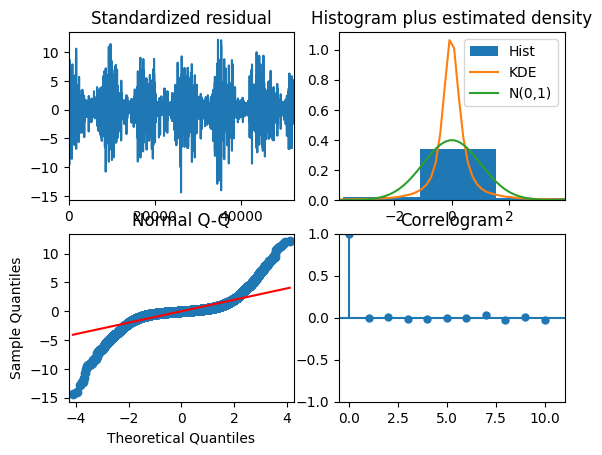

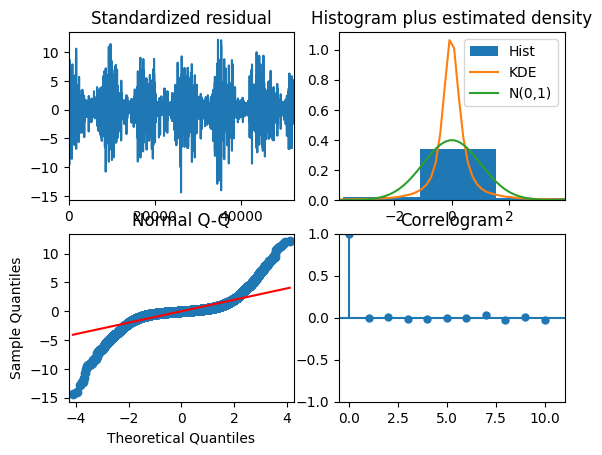

In [58]:
model.plot_diagnostics()

### 5.4 - Estimation des paramètres du modèle ARMAX

Maintenant que le modèle ARMAX(2,2) a été retenu, il reste à en estimer les paramètres. On va diviser les données en un jeu de données d'entraînement et un jeu de données de test. 

In [104]:
n = len(Y)
split_idx = int(n * 0.8)

Y_train = Y.iloc[:split_idx]
Y_test  = Y.iloc[split_idx:]

X_train = Y_t_scaled.iloc[:split_idx]
X_test  = Y_t_scaled.iloc[split_idx:]

Estimons à présent les paramètres du modèle ARMAX(2,2) à partir de l'échantilloj d'entrainement :

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                41839
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -258167.262
Date:                Mon, 29 Dec 2025   AIC                         516352.525
Time:                        18:10:30   BIC                         516430.299
Sample:                             0   HQIC                        516377.090
                              - 41839                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
T_t          -129.7671      5.456    -23.784      0.000    -140.461    -119.073
T_t_minus_1   214.8991      7.591     28.310      0.000     200.021     229.777
T_t_minus_2  -119.2549      5.667    -21.044    

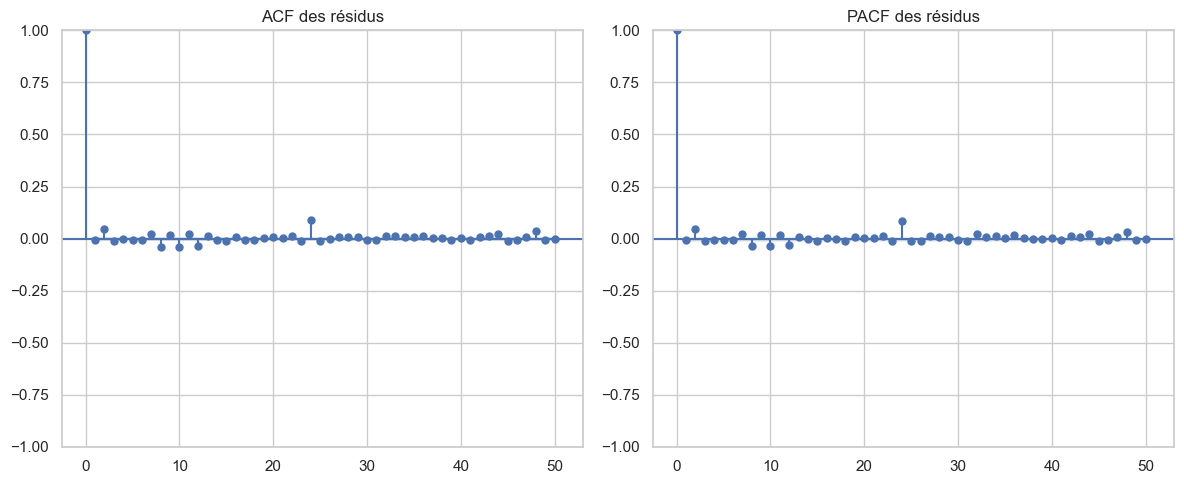

In [105]:
model = SARIMAX(
    Y_train,
    exog=X_train,
    order=(2, 0, 2),   # ARMAX(2,2)
    trend='n',         
    enforce_stationarity=True,
    enforce_invertibility=True
)

fitted_model = model.fit(disp=False)
print(fitted_model.summary())

residuals = fitted_model.resid

# ACF et PACF
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(residuals, ax=plt.gca(), lags=50)
plt.title('ACF des résidus')

plt.subplot(1,2,2)
plot_pacf(residuals, ax=plt.gca(), lags=50)
plt.title('PACF des résidus')

plt.tight_layout()
plt.show()

La fonction d'autocorrélation des résidus (ACF) présente un pic en zéro et est presque nulle ailleurs, de même pour la PACF, cela montre que les résidus obtenus sont bel et bien compatibles avec un bruit blanc. 

Pour terminer le travail de prédiction, réincorporons au résidu prédit les compsantes de tendance et saisonnières :

In [106]:
chemin_scripts = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(chemin_scripts)
from fonctions_conso import importation, clean, traitement_valeurs_manquantes
url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/csv?lang=fr&refine=libelle_metropole%3A%22M%C3%A9tropole%20du%20Grand%20Paris%22&facet=facet(name%3D%22libelle_metropole%22%2C%20disjunctive%3Dtrue)&timezone=Europe%2FParis&use_labels=true&delimiter=%3B"
df = traitement_valeurs_manquantes(clean(importation(url)))[['conso_final']]
df_red = df[(df.index.minute == 0) & (df.index.second == 0)]

stl_daily = STL(df_red['conso_final'], period=24, robust=True)
res_daily = stl_daily.fit()
deseason_daily = df_red['conso_final'] - res_daily.seasonal

stl_weekly = STL(deseason_daily, period=168, robust=True)
res_weekly = stl_weekly.fit()
deseason_weekly = deseason_daily - res_weekly.seasonal

stl_monthly = STL(deseason_weekly, period=720, robust=True)
res_monthly = stl_monthly.fit()

Après avoir recalculé les composantes saisonnières, nous pouvons calculer la consommation prédite pour la ville de Paris prenant en compte les variations de température :

In [136]:
epsilon_hat = fitted_model.predict(start=len(Y_train),end=len(Y_train) + len(Y_test) - 1,exog=X_test)

res_daily_season_test = res_daily.seasonal.iloc[Y_test.index[0]:Y_test.index[-1]+1]
res_weekly_season_test = res_weekly.seasonal.iloc[Y_test.index[0]:Y_test.index[-1]+1]
res_monthly_season_test = res_monthly.seasonal.iloc[Y_test.index[0]:Y_test.index[-1]+1]


# Reconstruction
season_test_aligned = (res_daily.seasonal.iloc[-len(epsilon_hat):] +
                       res_weekly.seasonal.iloc[-len(epsilon_hat):] +
                       res_monthly.seasonal.iloc[-len(epsilon_hat):])

trend_test_aligned = res_monthly.trend.iloc[-len(epsilon_hat):]

epsilon_hat.index = season_test_aligned.index
test_pred = epsilon_hat + season_test_aligned + trend_test_aligned

### 5.5 - Étude de la qualité de la prédiction

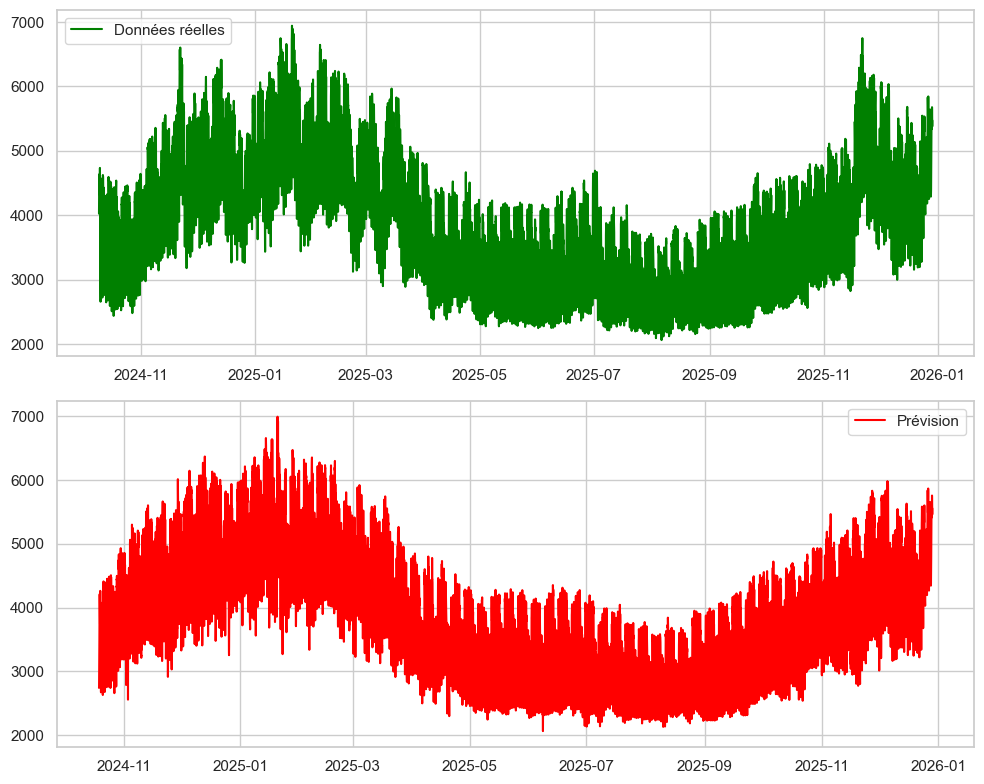

In [139]:
test_data = df_red['conso_final'].iloc[split_idx:]

#subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

#données réelles
ax1.plot(test_data, label="Données réelles", color="green")
ax1.legend()

#prédictions
ax2.plot(test_pred.index, test_pred.values, label='Prévision', color="red")
ax2.legend()

#afficher
plt.tight_layout()
plt.show()

A nouveau, les données prédites et réelles ont la même allure générale, ce qui est plutôt satisfaisant. Toutefois, l'anticipation brutale de la consommation électrique n'a à nouveau pas pu être prédite malgré l'ajout de la température comme variable exogène.

Regardons plus en détail les performances de notre nouvelle modélisation en terme de Mean Absolute Error (MAE) et Root Mean Squared Error (RMSE).

In [144]:
test_data_aligned = test_data.iloc[-len(test_pred):]

mse = mean_squared_error(test_data_aligned, test_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_aligned, test_pred)

delta = df_red['conso_final'].max() - df_red['conso_final'].min()
relative_rmse = rmse / delta
relative_mae = mae / delta
print(f"RMSE: {rmse}, Relative RMSE: {relative_rmse}")
print(f"MAE: {mae}, Relative MAE: {relative_mae}")

RMSE: 275.140696909555, Relative RMSE: 0.04765991631899446
MAE: 158.92193962640135, Relative MAE: 0.027528484258860446


On obtient une MAE relative de 2.75% et une RMSE de 4.77%, on améliore donc à cet égard les prédictions si l'on compare à l'ancien modèle, ne prenant pas en compte la météo, qui affichait une MAE relative de 2.79% et une RMSE relative de 5.7%.

Comme pour le modèle précédent, calculons la statistque de Theil, qui, pour rappel, permet de quantifier la capacité d'un modèle à prédire. Plus cette statistique est proche de zéro, plus le modèle est performant.

In [147]:
U = np.sqrt(np.mean((test_data_aligned - test_pred)**2)) / \
    (np.sqrt(np.mean(test_data_aligned**2)) + np.sqrt(np.mean(test_pred**2)))
print(U)

0.033121564421720394


On obtient une statistique de Theil de 0.033, inférieure à la statistique de Theil du précédent modèle qui était de 0.40. Nous avons bel et bien amélioré notre capacité à prédire les variations de la consommation électrique en prenant en compte les variations de la température. Ajouter d'autres variables exogènes, essayer d'ajouter des paramètres au modèle, voire recourir à des modèles lus sophistiqués pourrait permettre d'améliorer nos prédictions, ce que nous réservons éventuellement pour un prochain projet de DataScience.